# CPU Visualization of Single-cell Chromatin Accessibility

Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

In [37]:
%%time
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import time
import os, wget

import utils
import coverage

import warnings
warnings.filterwarnings('ignore', 'Expected ')

CPU times: user 8 µs, sys: 72 µs, total: 80 µs
Wall time: 84.2 µs


## Set parameters for analysis

In [29]:
# Number of peaks to retain
n_top_peaks = 20000

# PCA
n_components = 50

# KNN
n_neighbors=25
knn_n_pcs=50

# UMAP
umap_min_dist=0.3

pad=5000

## Downloads

In [3]:
%%time

FRAGMENTS_FILE = '../data/5k_pbmcs_10X_fragments.tsv.gz'
FRAGMENTS_INDEX_FILE = '../data/5k_pbmcs_10X_fragments.tsv.gz.tbi'
MATRIX_FILE = '../data/5k_pbmcs_10X.sparse.h5ad'

os.makedirs('../data', exist_ok=True)
os.makedirs('../models', exist_ok=True)

# Download Peak x cell matrix
if not os.path.exists(MATRIX_FILE):
    print('Downloading Peak x cell matrix...')
    !wget -O $MATRIX_FILE https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/5k_pbmcs_10X.sparse.h5ad

# Download fragments file
if not os.path.exists(FRAGMENTS_FILE):
    print('Downloading fragment file...')
    !wget -O $FRAGMENTS_FILE https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/5k_pbmcs_10X_fragments.tsv.gz
    !wget -O $FRAGMENTS_INDEX_FILE https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/5k_pbmcs_10X_fragments.tsv.gz.tbi

CPU times: user 287 µs, sys: 935 µs, total: 1.22 ms
Wall time: 4.95 ms


In [4]:
start_time = time.time()

## Load count matrix

In [5]:
%%time
adata = sc.read(MATRIX_FILE)
adata

CPU times: user 103 ms, sys: 129 ms, total: 231 ms
Wall time: 232 ms


AnnData object with n_obs × n_vars = 4654 × 84626

## Preprocessing

In [6]:
preprocessing_start = time.time()

### tf-idf normalization

In [7]:
%%time
lognormalized = utils.logtf_idf(adata.X, pseudocount=10**3)
adata.X = lognormalized

/rapids-genomics/rapids-single-cell-examples/notebooks/utils.py:87: RuntimeWarning: divide by zero encountered in true_divide
  log_inv_peak_freq = np.log1p(filtered_cells.shape[0] / peak_counts)


CPU times: user 1.45 s, sys: 586 ms, total: 2.03 s
Wall time: 2.03 s


### Frequency-based peak selection

In [8]:
%%time
adata = utils.filter_peaks(adata, n_top_peaks)
print(adata.X.shape)

(4654, 20000)
CPU times: user 560 ms, sys: 151 ms, total: 711 ms
Wall time: 709 ms


In [9]:
print("Preprocessing time: %.2fsec" % (time.time() - preprocessing_start))

Preprocessing time: 2.77sec


## Cluster & Visualize

### PCA

In [14]:
%%time
sc.tl.pca(adata, n_comps=n_components)
adata.obsm["X_pca"].shape

CPU times: user 2min 14s, sys: 26min 25s, total: 28min 40s
Wall time: 1min 44s


(4654, 50)

### UMAP

In [15]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist)

CPU times: user 18.3 s, sys: 36.9 s, total: 55.1 s
Wall time: 16.7 s


### Louvain clustering

In [20]:
%%time
sc.tl.louvain(adata)

CPU times: user 630 ms, sys: 154 ms, total: 784 ms
Wall time: 1.21 s


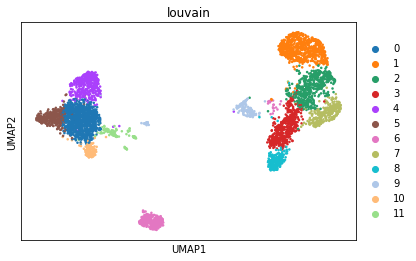

In [21]:
sc.pl.umap(adata, color=['louvain'])

In [118]:
%%time
clusters = pd.Series(adata.obs['louvain']).reset_index()
clusters.columns = ['cell', 'cluster']
clusters.head()

CPU times: user 224 µs, sys: 2.32 ms, total: 2.54 ms
Wall time: 2.5 ms


,cell,cluster
0,AAACGAAAGCGCAATG-1,5
1,AAACGAAAGGGTATCG-1,0
2,AAACGAAAGTAACATG-1,3
3,AAACGAAAGTTACACC-1,3
4,AAACGAACAGAGATGC-1,0
